In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [41]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "30g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

In [42]:
base_path = "/data/saturation/test_updates/"

configs_pdf, configs_df, configs_dict = get_configs(
    base_path=base_path,
    spark=spark,
)

25/02/13 13:31:21 WARN CacheManager: Asked to cache already cached data.


In [43]:
configs_pdf[configs_pdf.slope.between(-5.1, -4.8)].sort_values("simulation_id")

,mrp,rim_erasure_method,rmin,rmult,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio
0,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,1,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
7,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,1,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
2,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,5,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
6,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,10,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
1,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,25,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
3,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,50,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
4,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,75,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0
5,0.5,"{'name': None, 'ratio': 5.0, 'exponent': 1.0}",0.22,1.0,100,-5.0,"{'name': 'nstat', 'nstat': '10000000'}",1500,12000,1.0,5.0


## Example CSFD

In [44]:
simulation_id = 10
b_p = configs_dict[simulation_id]["slope"]
young_target_nstat = 5e2
older_target_nstat = 3e4
oldest_target_nstat = int(1.5e6)

r_stat = configs_dict[simulation_id]["rstat"]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = simulation_id
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

young_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=young_target_ngen,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark

)

older_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=older_target_ngen,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark
)

oldest_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=oldest_target_ngen,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark
)   

In [45]:
oldest_state.describe()

,x,y,radius
count,40157.000000,40157.000000,40157.000000
mean,7527.196738,7508.507776,4.799980
std,3461.776931,3470.377969,2.081956
min,1500.348758,1500.200756,3.000095
25%,4553.894611,4484.458445,3.421590
50%,7557.856388,7532.137377,4.094794
75%,10519.835923,10518.505571,5.435260
max,13499.624919,13499.724610,58.898690


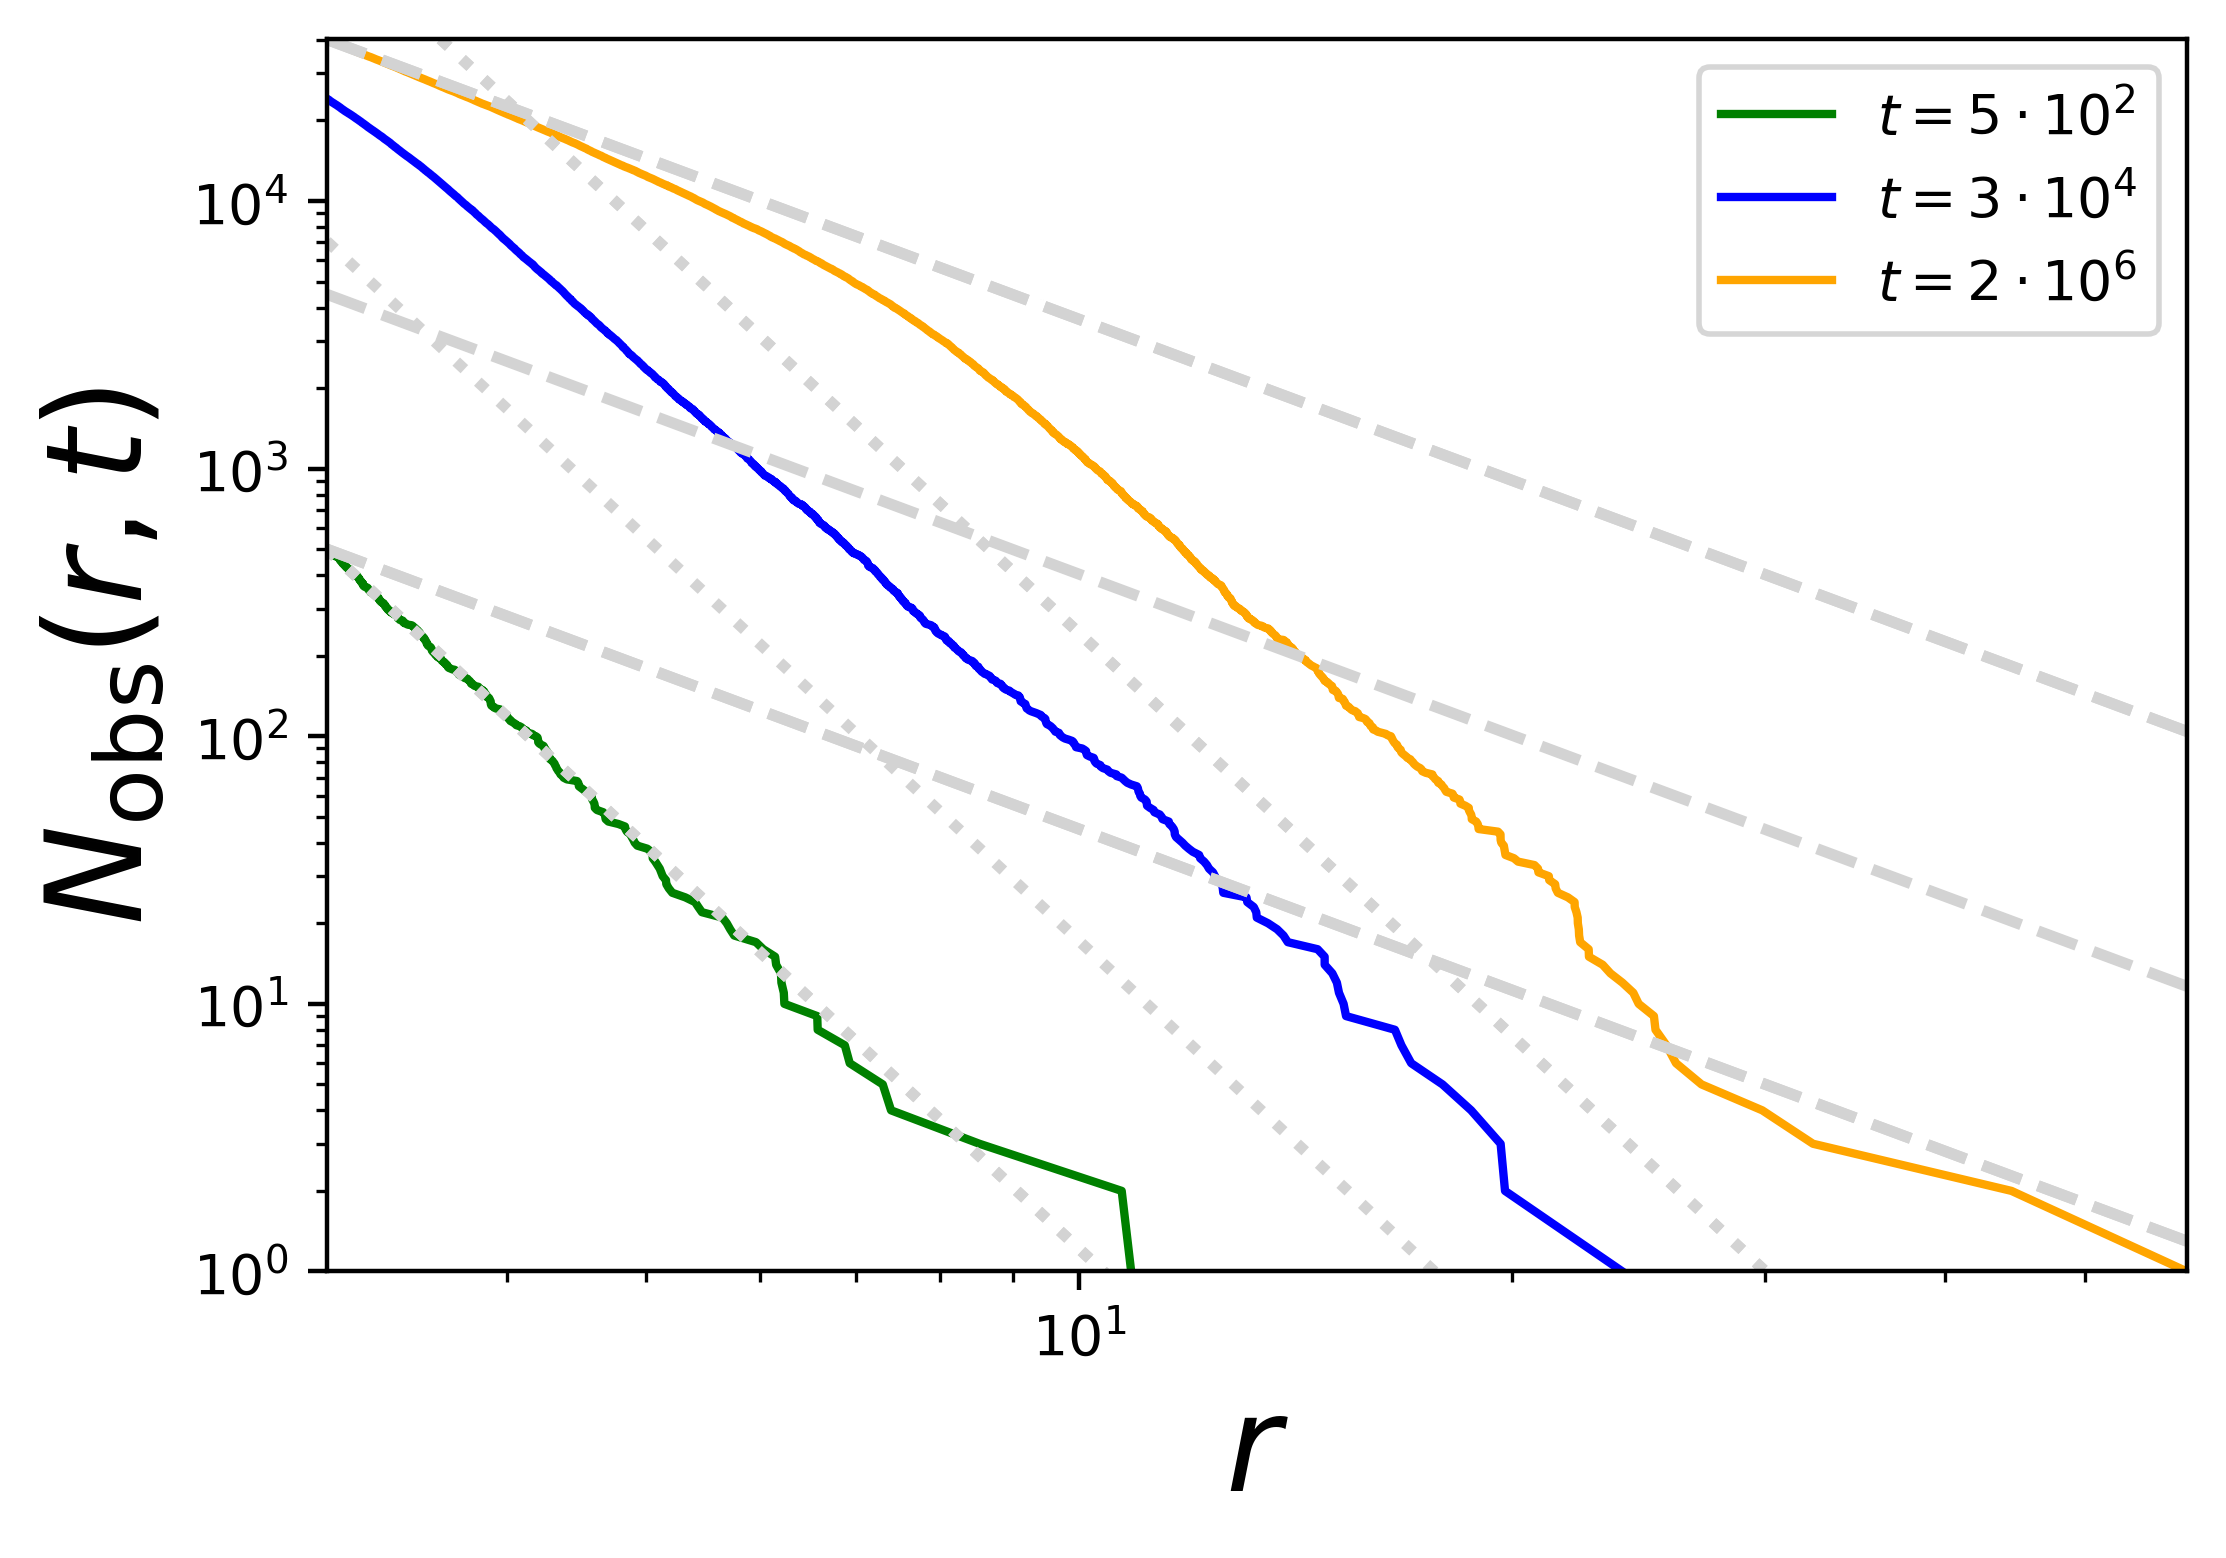

25/02/13 13:32:41 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-524faf16-da4b-43ec-8deb-261c5a3eb877. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-524faf16-da4b-43ec-8deb-261c5a3eb877
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:173)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimize

In [48]:
font_size = 24
n_lines_below = 0
n_lines_above = 0
n_geometric_saturation_ref_lines = 3
n_production_ref_lines = 3

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
nobs_young = young_radii.count()
nobs_old = oldest_radii.count()
min_r_ref = oldest_radii.min()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax = fig.add_subplot(111)

# Plot young state
observed_young_y = range(len(young_radii), 0, -1)
ax.plot(young_radii, observed_young_y, label=f"$t={get_scientific_notation(young_target_nstat, 0)}$", color="green")

# Plot older state
observed_older_y = range(len(older_radii), 0, -1)
ax.plot(older_radii, observed_older_y, label=f"$t={get_scientific_notation(older_target_nstat, 0)}$", color="blue")

# Plot old state
observed_oldest_y = range(len(oldest_radii), 0, -1)
ax.plot(oldest_radii, observed_oldest_y, label=f"$t={get_scientific_notation(oldest_target_nstat, 0)}$", color="orange")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(oldest_radii.min()), np.log10(oldest_radii.max()), 100)

young_geometric_saturation_intercept = nobs_young / min_r_ref ** -2
young_production_intercept = nobs_young / min_r_ref ** b_p

old_geometric_saturation_intercept = nobs_old / min_r_ref ** -2
old_production_intercept = nobs_old / min_r_ref ** b_p

intercepts = np.logspace(
    start=np.log10(young_geometric_saturation_intercept),
    stop=np.log10(old_geometric_saturation_intercept),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
geometric_saturation_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

intercepts = np.logspace(
    start=np.log10(young_production_intercept),
    stop=np.log10(young_production_intercept * 200),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
production_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

reference_lines = {
    -2: {
        "intercepts": geometric_saturation_intercepts,
        "style": "dashed"
    },
    b_p: {
        "intercepts": production_intercepts,
        "style": "dotted"
    }
}

for b_ref, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**b_ref
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(oldest_radii.min(), oldest_radii.max())
ax.set_ylim(min(observed_oldest_y), max(observed_oldest_y))

# Labels and scaling
ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N_{\\text{obs}}(r, t)$", fontsize=font_size)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/example_csfds.png", bbox_inches="tight")

plt.show()

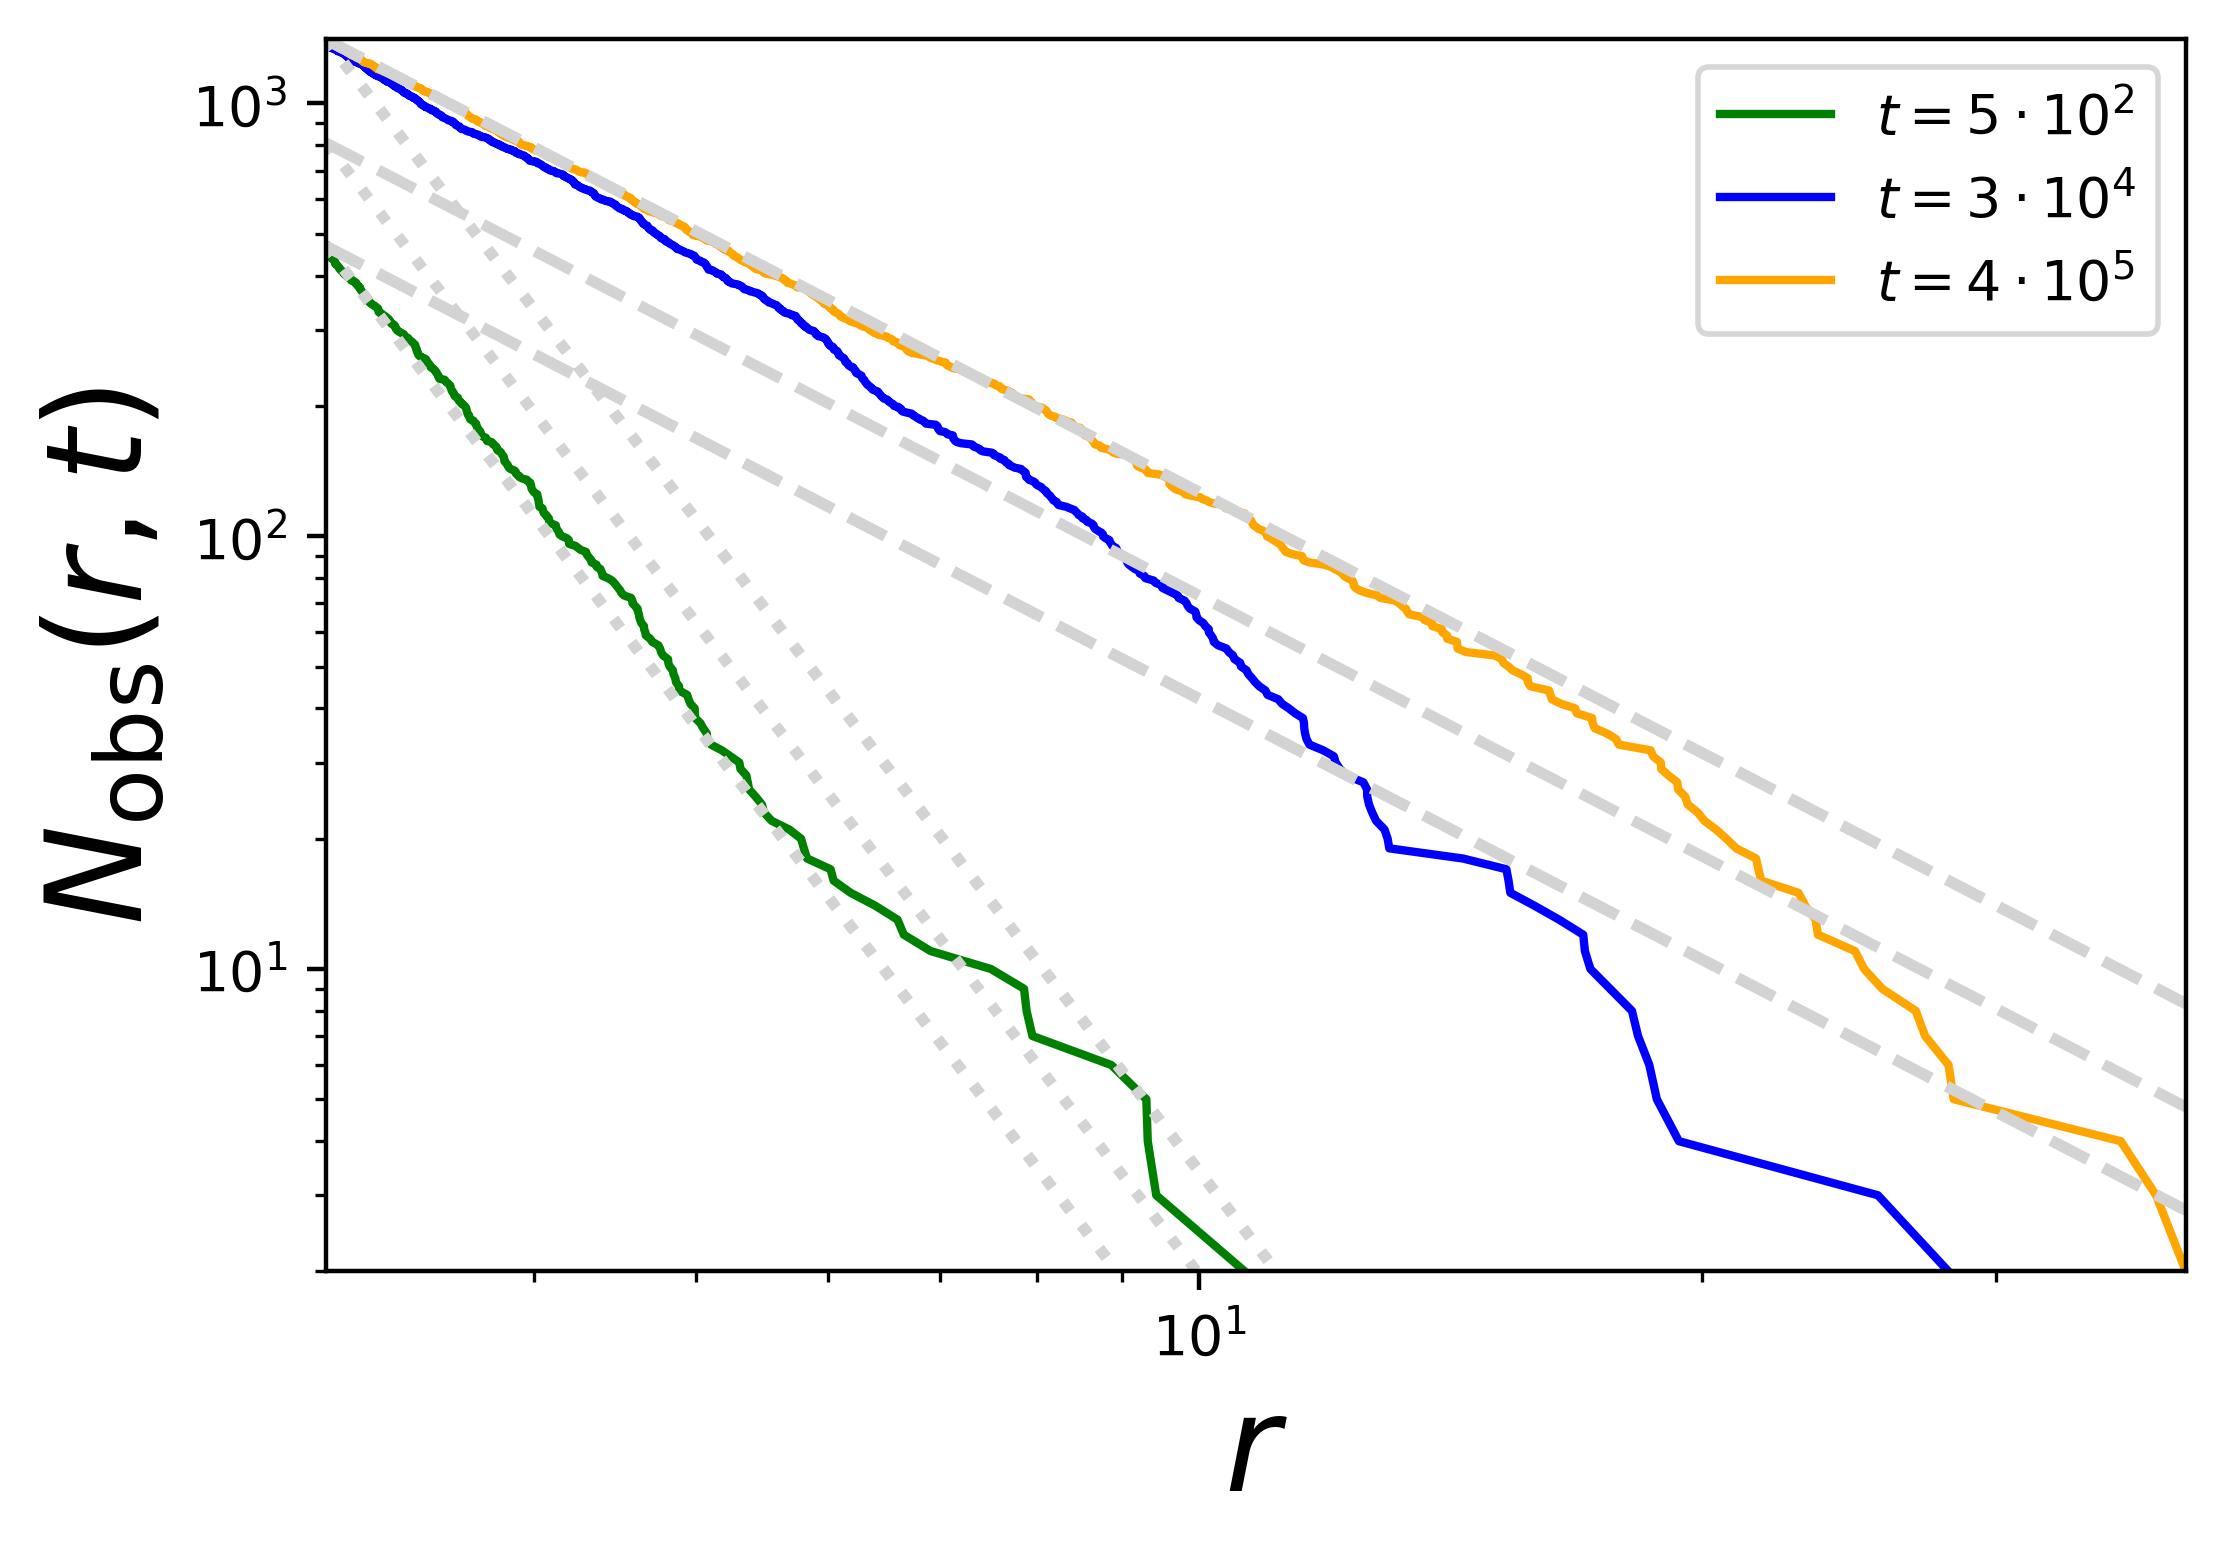

In [19]:
font_size = 24
n_lines_below = 0
n_lines_above = 0
n_geometric_saturation_ref_lines = 3
n_production_ref_lines = 3

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
nobs_young = young_radii.count()
nobs_old = oldest_radii.count()
min_r_ref = oldest_radii.min()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax = fig.add_subplot(111)

# Plot young state
observed_young_y = range(len(young_radii) + 1, 1, -1)
ax.plot(young_radii, observed_young_y, label=f"$t={get_scientific_notation(young_target_ngen, 0)}$", color="green")

# Plot older state
observed_older_y = range(len(older_radii) + 1, 1, -1)
ax.plot(older_radii, observed_older_y, label=f"$t={get_scientific_notation(older_target_ngen, 0)}$", color="blue")

# Plot old state
observed_oldest_y = range(len(oldest_radii) + 1, 1, -1)
ax.plot(oldest_radii, observed_oldest_y, label=f"$t={get_scientific_notation(oldest_target_ngen, 0)}$", color="orange")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(oldest_radii.min()), np.log10(oldest_radii.max()), 100)

young_geometric_saturation_intercept = nobs_young / min_r_ref ** -2
young_production_intercept = nobs_young / min_r_ref ** b_p

old_geometric_saturation_intercept = nobs_old / min_r_ref ** -2
old_production_intercept = nobs_old / min_r_ref ** b_p

intercepts = np.logspace(
    start=np.log10(young_geometric_saturation_intercept),
    stop=np.log10(old_geometric_saturation_intercept),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
geometric_saturation_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

intercepts = np.logspace(
    start=np.log10(young_production_intercept),
    stop=np.log10(old_production_intercept),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
production_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

reference_lines = {
    -2: {
        "intercepts": geometric_saturation_intercepts,
        "style": "dashed"
    },
    b_p: {
        "intercepts": production_intercepts,
        "style": "dotted"
    }
}

for b_ref, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**b_ref
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(oldest_radii.min(), oldest_radii.max())
ax.set_ylim(min(observed_oldest_y), max(observed_oldest_y))

# Labels and scaling
ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N_{\\text{obs}}(r, t)$", fontsize=font_size)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/example_csfds.png", bbox_inches="tight")

plt.show()

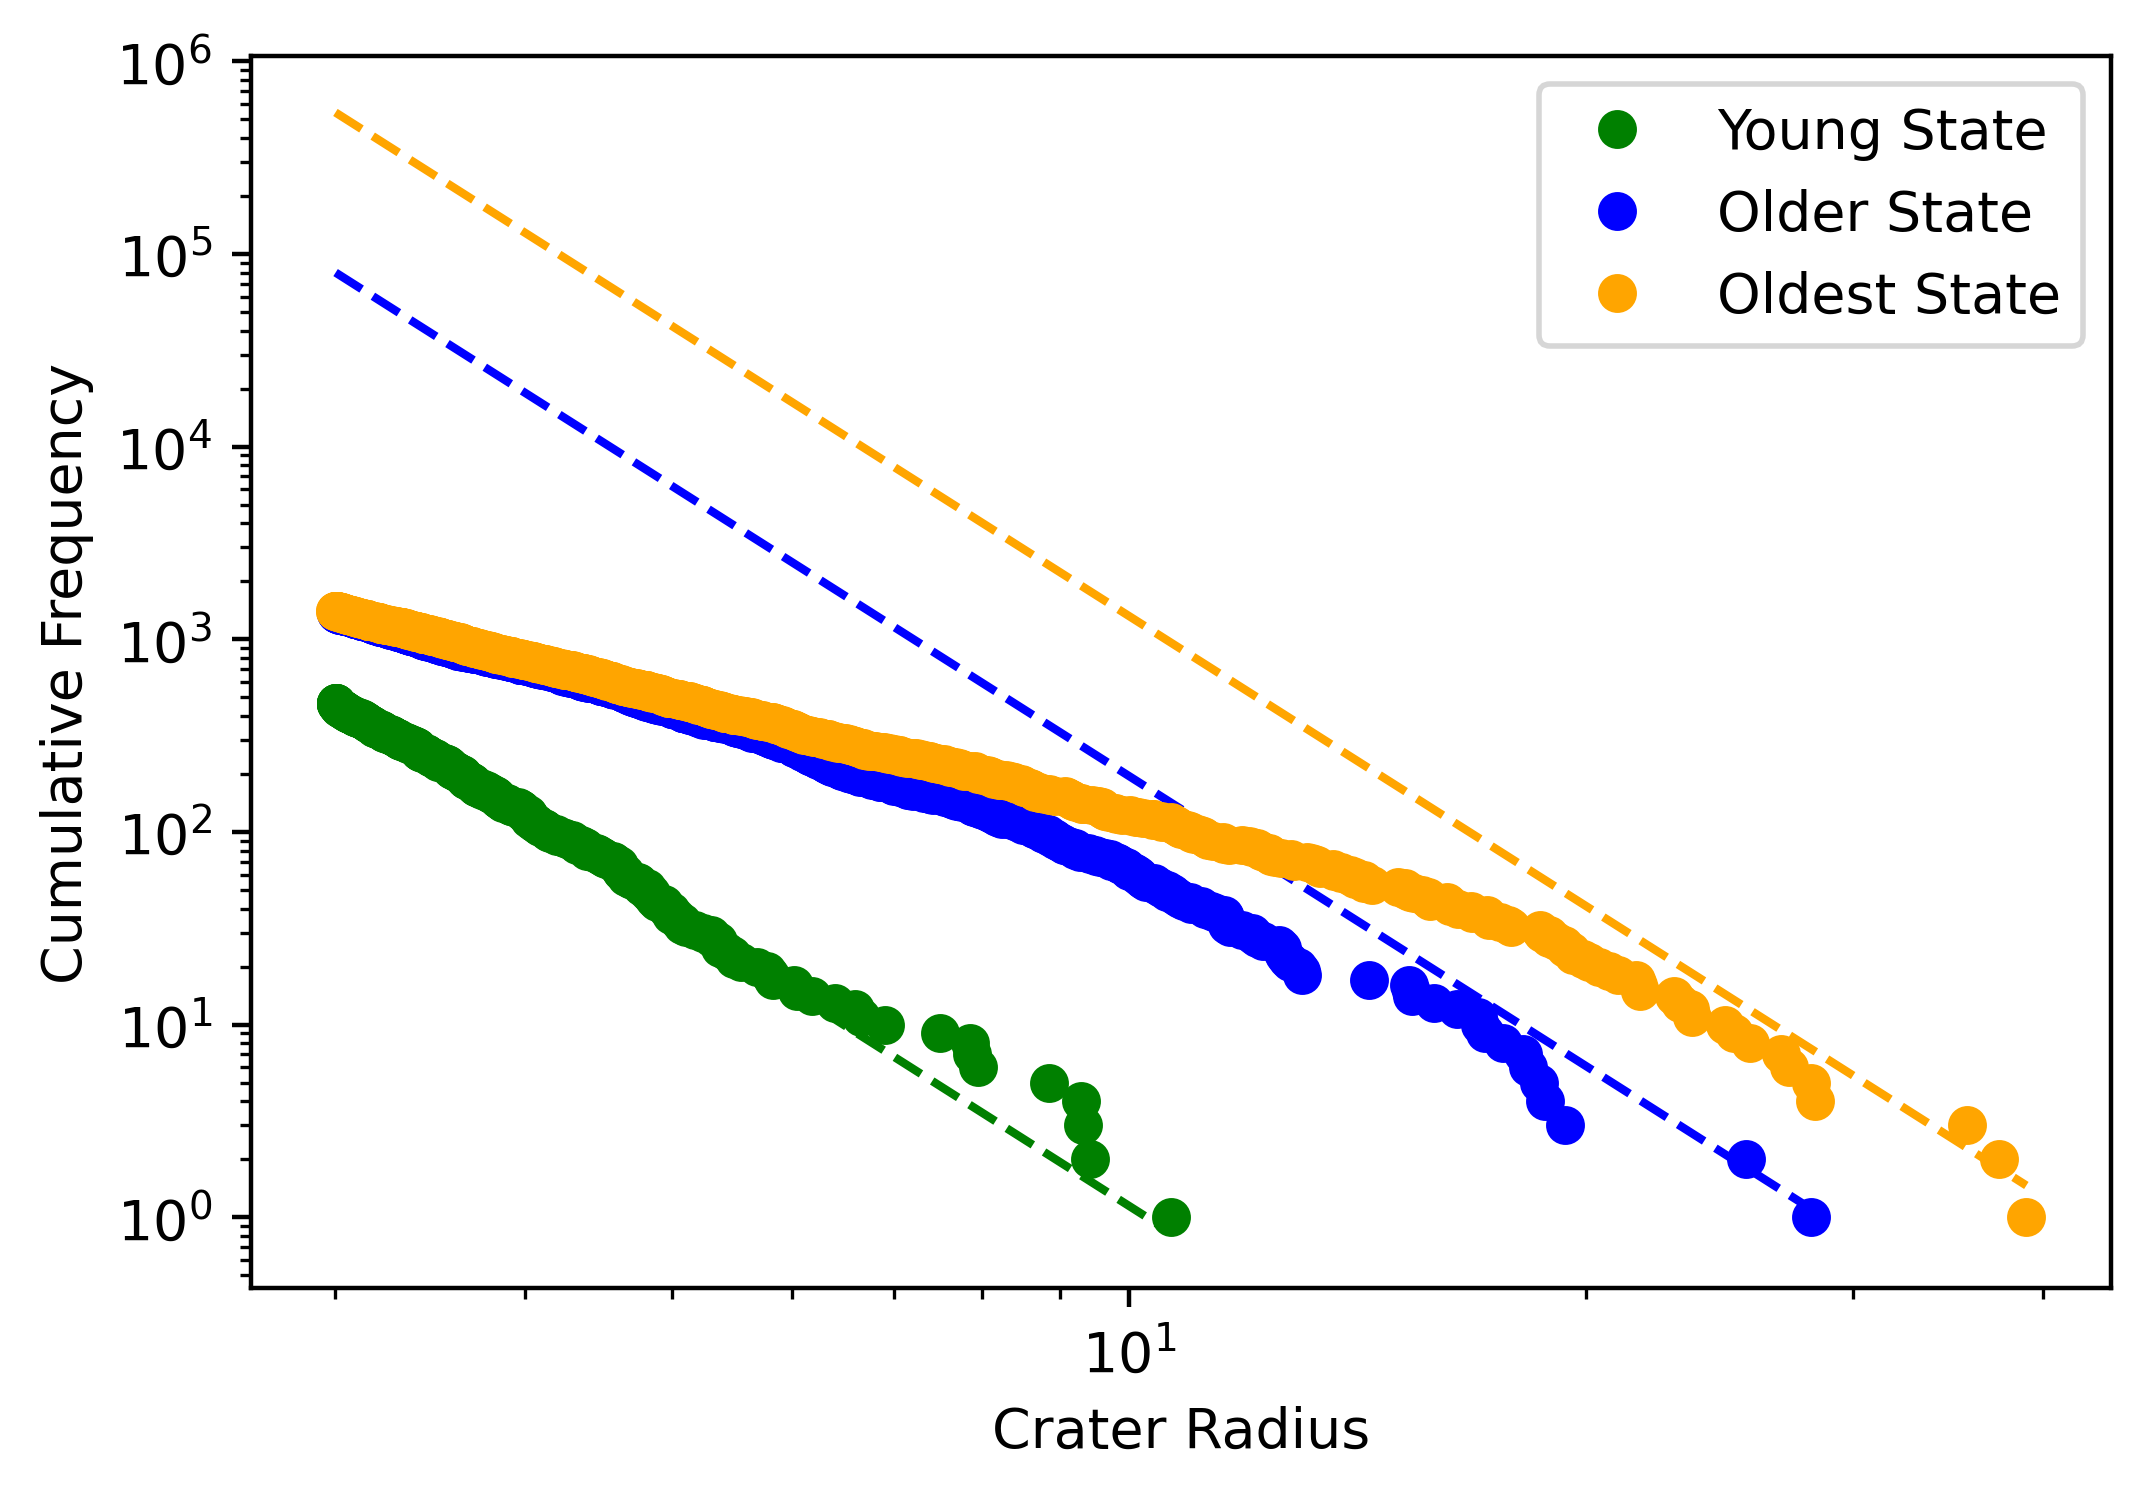

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def find_quasi_linear_region(log_radii, log_counts, sigma=2, threshold=0.01):
    """
    Identify the quasi-linear region of a CSFD on a log-log plot.
    """
    # Smooth the log-transformed counts
    smoothed_log_counts = gaussian_filter1d(log_counts, sigma=sigma)

    # Compute the second derivative
    second_derivative = np.gradient(np.gradient(smoothed_log_counts, log_radii), log_radii)

    # Identify indices where the second derivative is below the threshold
    linear_region_mask = np.abs(second_derivative) < threshold
    linear_indices = np.where(linear_region_mask)[0]

    if len(linear_indices) == 0:
        raise ValueError("No quasi-linear region found. Adjust 'sigma' or 'threshold' parameters.")

    # Group consecutive indices to find continuous linear regions
    groups = np.split(linear_indices, np.where(np.diff(linear_indices) != 1)[0] + 1)

    # Select the largest continuous group as the quasi-linear region
    largest_group = max(groups, key=len)
    return largest_group[0], largest_group[-1]

def compute_intercept(log_radii, log_counts, slope, start_idx, end_idx):
    """
    Compute the intercept for a given slope that best fits the quasi-linear region.
    """
    linear_log_radii = log_radii[start_idx:end_idx + 1]
    linear_log_counts = log_counts[start_idx:end_idx + 1]
    intercept = np.mean(linear_log_counts) - slope * np.mean(linear_log_radii)
    return intercept

def plot_csfd_with_reference_line(radii, counts, slope, label, color, sigma=2, threshold=0.01):
    """
    Plot the CSFD and the reference line with the specified slope.
    """
    # Log-transform the data
    log_radii = np.log10(radii)
    log_counts = np.log10(counts)

    # Find the quasi-linear region
    start_idx, end_idx = find_quasi_linear_region(log_radii, log_counts, sigma, threshold)

    # Compute the intercept
    intercept = compute_intercept(log_radii, log_counts, slope, start_idx, end_idx)

    # Define the reference line function
    def reference_line(r):
        return 10**(intercept) * r**slope

    # Plot the CSFD
    plt.loglog(radii, counts, label=label, color=color, marker='o', linestyle='')

    # Plot the reference line
    r_fit = np.linspace(radii.min(), radii.max(), 100)
    plt.loglog(r_fit, reference_line(r_fit), linestyle='--', color=color)

font_size = 24
n_lines_below = 0
n_lines_above = 0
n_geometric_saturation_ref_lines = 3
n_production_ref_lines = 3

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
young_counts = np.arange(len(young_radii), 0, -1)
older_counts = np.arange(len(older_radii), 0, -1)
oldest_counts = np.arange(len(oldest_radii), 0, -1)
nobs_young = young_radii.count()
nobs_old = oldest_radii.count()
min_r_ref = oldest_radii.min()

# Plot each CSFD with its reference line
plt.figure(figsize=(6, 4), dpi=400)
plot_csfd_with_reference_line(young_radii, young_counts, slope=b_p, label='Young State', color='green', threshold=50)
plot_csfd_with_reference_line(older_radii, older_counts, slope=b_p, label='Older State', color='blue', sigma=500)
plot_csfd_with_reference_line(oldest_radii, oldest_counts, slope=b_p, label='Oldest State', color='orange', sigma=500)

# Labels and legend
plt.xlabel('Crater Radius')
plt.ylabel('Cumulative Frequency')
plt.legend()
plt.show()
